# Lines Generator

In [1]:
from matplotlib import pyplot as plt 
from skimage.draw import line_aa
import numpy as np
import cv2
%matplotlib inline

## Parameters

In [2]:
size = (1280,720)

#lines
delta_lines = [3,30]
aplha_lines = [0.5,1]

#texture
n_textures = 3
alpha_textures = [0.05, 0.2] #max=1

#binary noise
binary_noise_probability = 0.005 #max=1

#smoothing
smooth_delta_kernel = [3,11] #[3,7] => (3,3)or(5,5)or(7,7)

#simple noise
noise_delta_sigma = [-30,30] #max=255

## Aux function

In [3]:
def imshow(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    plt.show()

In [4]:
def norm(im):
    im = np.array(im).astype('float32')
    im = (im-np.min(im))*255/(np.max(im)-np.min(im))
    return im.astype('uint8')

In [5]:
im = np.zeros((size[1],size[0]))

## Add Lines

In [6]:
def add_lines(im,delta_lines,aplha_lines):
    im = im.copy()

    #Parameters
    size = im.shape
    d_max = np.floor(np.sqrt(size[0]**2+size[1]**2))-10
    n_lines = np.random.randint(delta_lines[0],delta_lines[1])
    
    #add lines
    lines = list()
    for l in range(n_lines):

        #random line
        dist = np.random.random()*d_max
        angle = np.random.random()*2*np.pi-np.pi
        alpha = np.random.random()*(aplha_lines[1]-aplha_lines[0])+aplha_lines[0]

        #save
        lines.append([dist,angle,alpha])

        #to rectangle
        pt1 = np.around(dist/np.sin(angle))                         #x=0     => [0,d/sin(o)]
        pt2 = np.around((dist-size[1]*np.cos(angle))/np.sin(angle)) #x=x_max => [x_max,(d-x_max.cos(o))/sin(o)]

        #line pixels
        rows, cols, vals = line_aa(int(pt1), 0, int(pt2), size[1])
        for r,c,v in zip(rows, cols, vals):
            try:
                im[c][r] = v*alpha
            except:#out matrix
                break
    
    return np.array(lines), norm(im)

5 lines


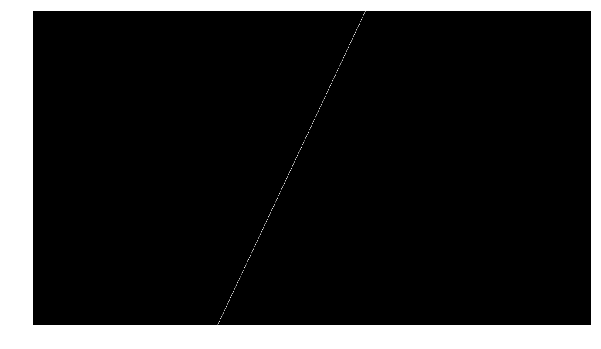

CPU times: user 306 ms, sys: 169 ms, total: 475 ms
Wall time: 264 ms


In [7]:
%%time
lines,im = add_lines(im,delta_lines,aplha_lines)
print(lines.shape[0],'lines')
imshow(im)

## Texture
Load all textures:

In [8]:
def load_textures(n_textures):

    ims_texture = list()
    for t in range(n_textures):
        #load
        ims_texture.append(cv2.imread('imgs/texture'+str(t+1)+'.jpg',cv2.IMREAD_GRAYSCALE))
        #resize
        ims_texture[-1] = cv2.resize(ims_texture[-1], size)
        #normalize
        ims_texture[-1] = norm(ims_texture[-1])

    return np.array(ims_texture)

Add texture:

In [9]:
def add_texture(im, ims_texture,alpha_textures):
    im = im.copy()
    
    #random texture
    n_textures = ims_texture.shape[0]
    i_texture = np.random.randint(0,n_textures)
    alpha = np.random.random()*(alpha_textures[1]-alpha_textures[0])+alpha_textures[0]

    #add 
    im = im+ims_texture[i_texture]*alpha

    #print('i:',i_texture,' alpha:',alpha)
    return norm(im)

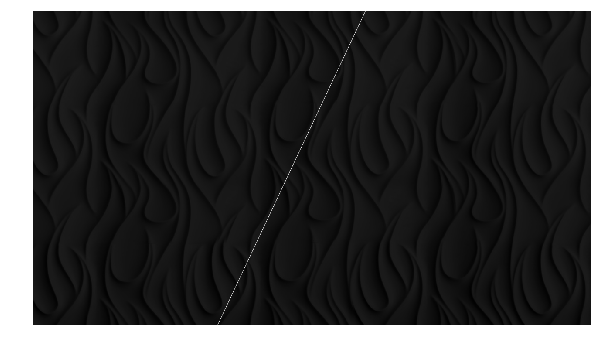

CPU times: user 356 ms, sys: 192 ms, total: 548 ms
Wall time: 315 ms


In [10]:
%%time
ims_texture = load_textures(n_textures)
im = add_texture(im, ims_texture,alpha_textures)
imshow(im)

## Binary Noise

In [11]:
def add_binary_noise(im,noise_probability):
    im = im.copy().astype('int16')
    
    #random image [0,1]
    im_prob = np.random.random(im.shape)

    #invert some pixels 
    #im[im_prob<noise_probability] = 255-im
    im[im_prob<noise_probability] *= -1
    im[im_prob<noise_probability] += 255
         
    return norm(im)

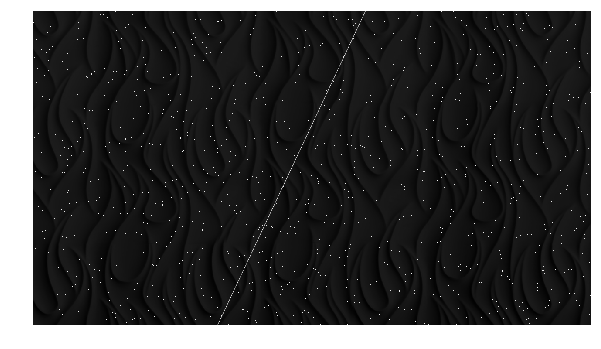

CPU times: user 332 ms, sys: 162 ms, total: 494 ms
Wall time: 278 ms


In [12]:
%%time
im = add_binary_noise(im,binary_noise_probability)
imshow(im)

## Smoothing

In [13]:
def smoothing(im,delta_kernel):
    im = im.copy()
    
    #random kernel, only odd
    kernel = np.random.randint(delta_kernel[0]/2,delta_kernel[1]/2+1)
    kernel = kernel*2+1
    
    #gaussian filter
    im = cv2.GaussianBlur(im,(kernel,kernel),-1)

    return norm(im)

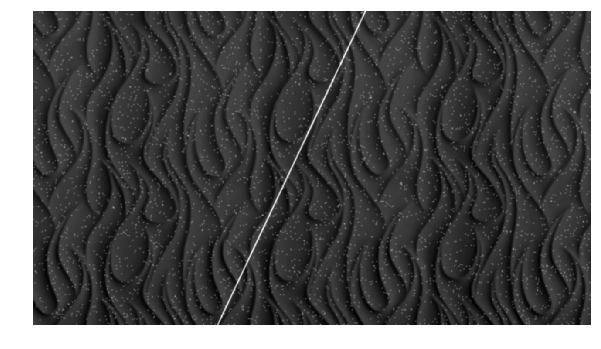

CPU times: user 316 ms, sys: 178 ms, total: 495 ms
Wall time: 270 ms


In [14]:
%%time
im = smoothing(im,smooth_delta_kernel)
imshow(im)

## Noise

In [15]:
def add_noise(im,delta_sigma):
    im = im.copy()
    
    #random noise
    im_noise = np.random.randint(delta_sigma[0],delta_sigma[1],im.shape)
    im_noise = im + im_noise
    
    #limits
    im_noise[im_noise>255] = 255
    im_noise[im_noise<0] = 0
    
    return norm(im_noise)

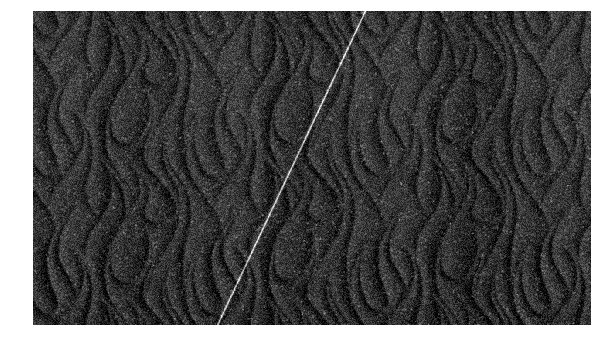

CPU times: user 415 ms, sys: 172 ms, total: 587 ms
Wall time: 363 ms


In [16]:
%%time
im = add_noise(im,noise_delta_sigma)
imshow(im)

## Image generator

In [17]:
def im_generator(n_images=1,
                 size = (1280,720),
                 delta_lines = [3,30],
                 aplha_lines = [0.5,1],
                 n_textures = 3,
                 alpha_textures = [0.05, 0.2],
                 binary_noise_probability = 0.005,
                 smooth_delta_kernel = [3,11],
                 noise_delta_sigma = [-30,30]):
    
    #load textures
    ims_texture = load_textures(n_textures)
    
    ims = list()
    lines_list = list()
    for i in range(n_images):
        #black image
        im = np.zeros((size[1],size[0]))

        #Add Lines
        lines,im = add_lines(im,delta_lines,aplha_lines)

        #Add Texture
        im = add_texture(im, ims_texture,alpha_textures)

        #Add Binary Noise
        im = add_binary_noise(im,binary_noise_probability)

        #Smoothing
        im = smoothing(im,smooth_delta_kernel)

        #Add Noise
        im = add_noise(im,noise_delta_sigma)
    
        #Lines
        ims.append(im)
        lines_list.append(lines)
    
    #to numpy
    ims = np.array(ims)
    lines_list = np.array(lines_list)
    
    return lines_list,ims

(1, 17, 3)


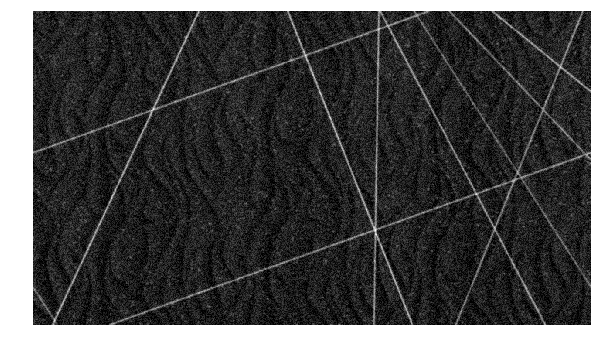

CPU times: user 574 ms, sys: 189 ms, total: 763 ms
Wall time: 532 ms


In [21]:
%%time
lines, ims = im_generator()
print(lines.shape)
imshow(ims[0])

In [22]:
%%time
lines,ims = im_generator(10)

CPU times: user 2.34 s, sys: 297 ms, total: 2.63 s
Wall time: 2.62 s


0 (14, 3)


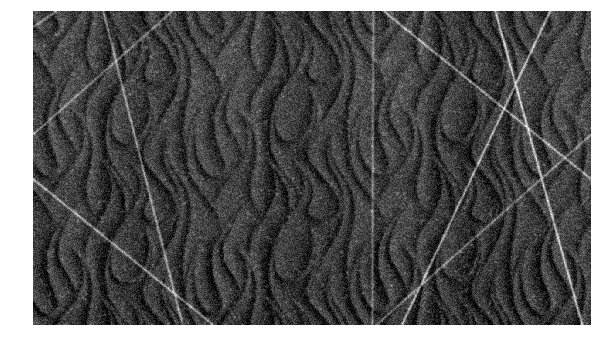

1 (7, 3)


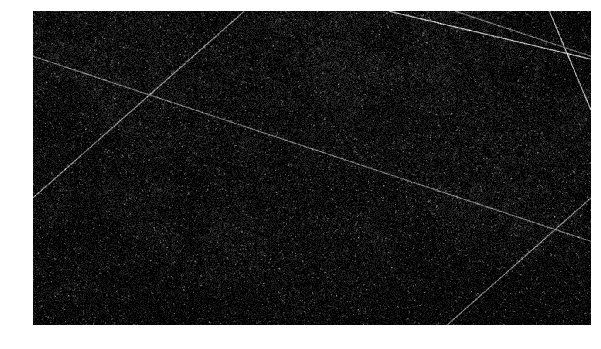

2 (24, 3)


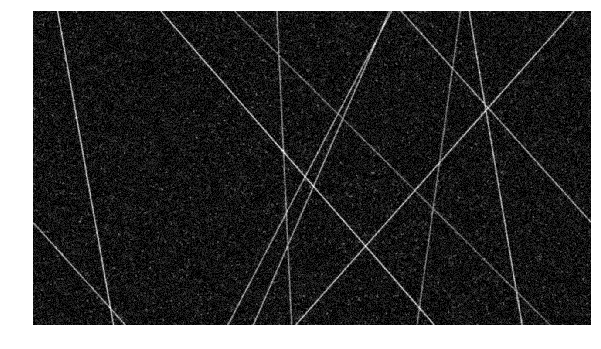

3 (26, 3)


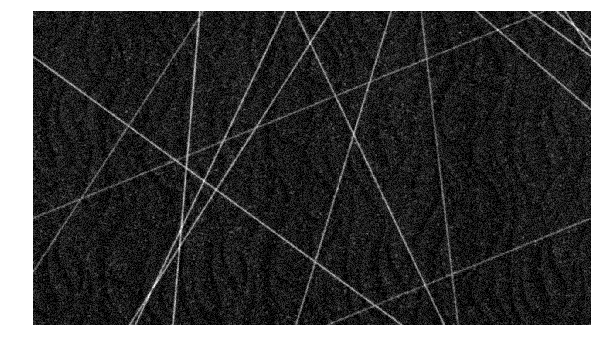

4 (28, 3)


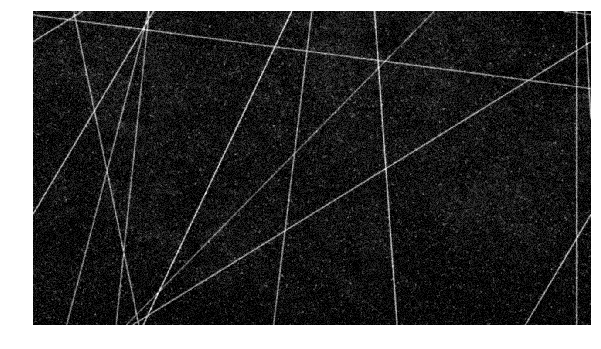

5 (20, 3)


6 (21, 3)


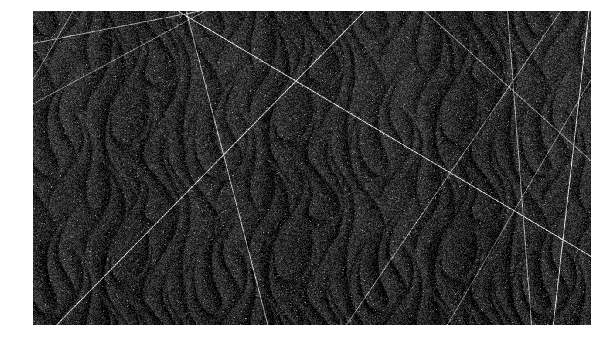

7 (25, 3)


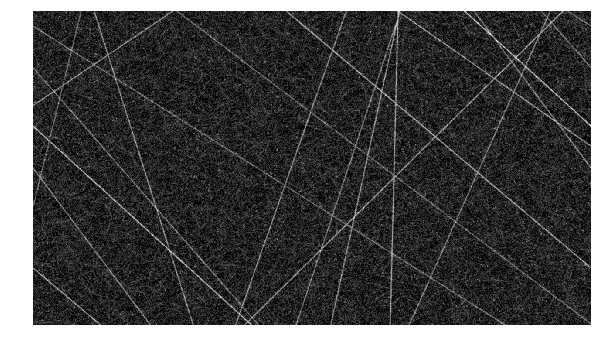

8 (28, 3)


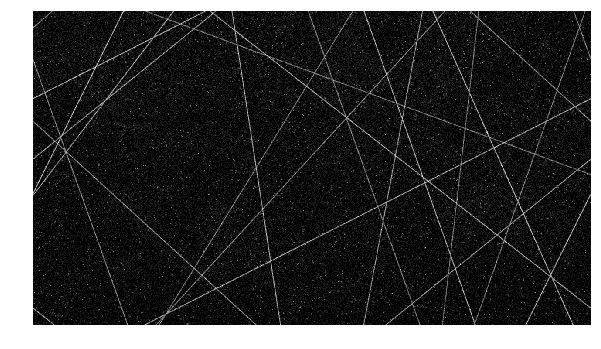

9 (16, 3)


CPU times: user 4.99 s, sys: 1.52 s, total: 6.52 s
Wall time: 4.6 s


In [23]:
%%time
for i in range(10):
    print(i,lines[i].shape)
    imshow(ims[i])